In [1]:
import torch
import numpy as np
import glob
import os
from datasets.datasets import Dataset_2H
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [2]:
class Dataset_coord(Dataset):
    def __init__(self, base_path='F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\pos_2H'):
        self.base_path = base_path
        self.pos_files = glob.glob(os.path.join(base_path, '*_pos.npy'))
        self.label_files = glob.glob(os.path.join(base_path, '*_label.npy'))

    def __len__(self):
        return len(self.pos_files)

    def __getitem__(self, index):
        # pos = torch.as_tensor(np.load(self.pos_files[index]))[:, :-1]
        pos = torch.as_tensor(np.load(self.pos_files[index]))
        label = torch.as_tensor(np.load(self.label_files[index]), dtype=torch.long)
        return pos, label

In [3]:
# 加载数据集
dataset_image = Dataset_2H()
dataset_coord = Dataset_coord()

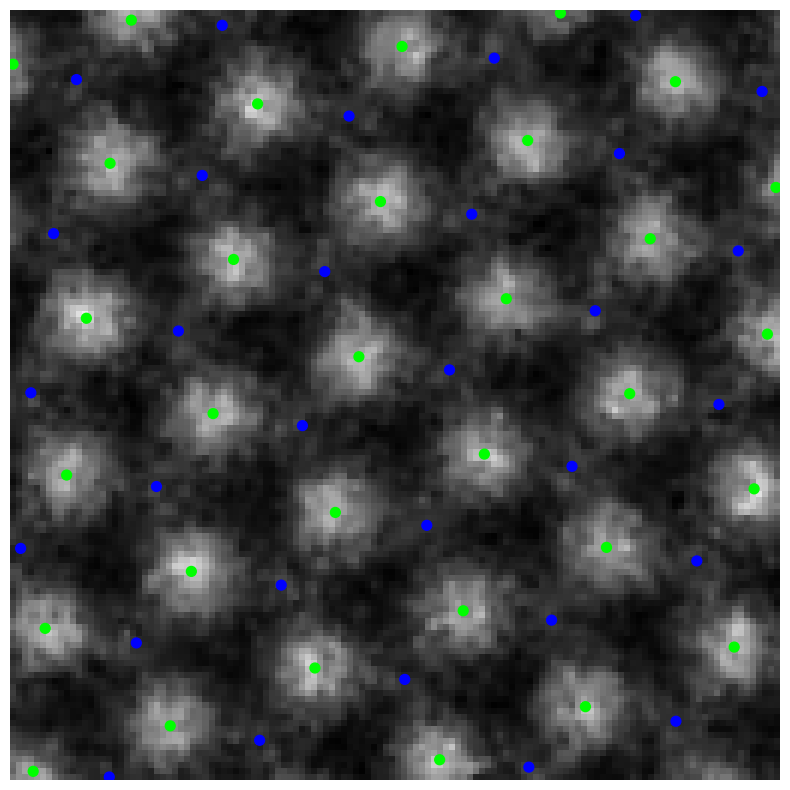

In [4]:
image, _ = dataset_image[0]
coord, label = dataset_coord[0]

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.5, cbar_mode=None, cbar_size="5%", cbar_pad="2%")

im = grid[0].imshow(image[0], cmap='gray')
im = grid[0].scatter(coord[:, 0], coord[:, 1], c=label, s=50, cmap='brg')
grid[0].invert_yaxis()
grid[0].axis('off')
grid.cbar_axes[0].colorbar(im)

In [5]:
def compute_distances(points):
    # 扩展维度，使得 points 的形状变为 (N, 1, 2) 和 (1, N, 2)
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    # 计算距离
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    return distances

In [6]:
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, load_from_file=False):
        super(CustomDataset, self).__init__()
        self.data_list = []
        if load_from_file:
            self.load()
        else:
            for i in tqdm(range(len(dataset_coord))):
                coord, label = dataset_coord[i]
                coord = coord.numpy()
                distances = compute_distances(coord[:, :2])
                np.fill_diagonal(distances, np.inf)
                min_value = np.min(distances)
                connections = (distances <= min_value * 1.5)
                np.fill_diagonal(connections, False)
                
                edge_index = np.argwhere(connections)
                edge_index = np.concatenate((edge_index, edge_index[:, [1, 0]]), axis=0)
                data = Data(x=torch.as_tensor(coord, dtype=torch.float32),
                            edge_index=torch.as_tensor(edge_index, dtype=torch.long).T,
                            y=label)
                self.data_list.append(data)

    def len(self):
        return len(self.data_list)
    
    def save(self):
        torch.save(self.data_list, './datasets/gnn/dataset_2H.pt')
        
    def load(self):
        self.data_list = torch.load('./datasets/gnn/dataset_2H.pt')

    def get(self, idx):
        return self.data_list[idx]

In [7]:
dataset = CustomDataset(load_from_file=True)
train_loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [8]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(dataset[10], node_attrs=['x', 'y'])

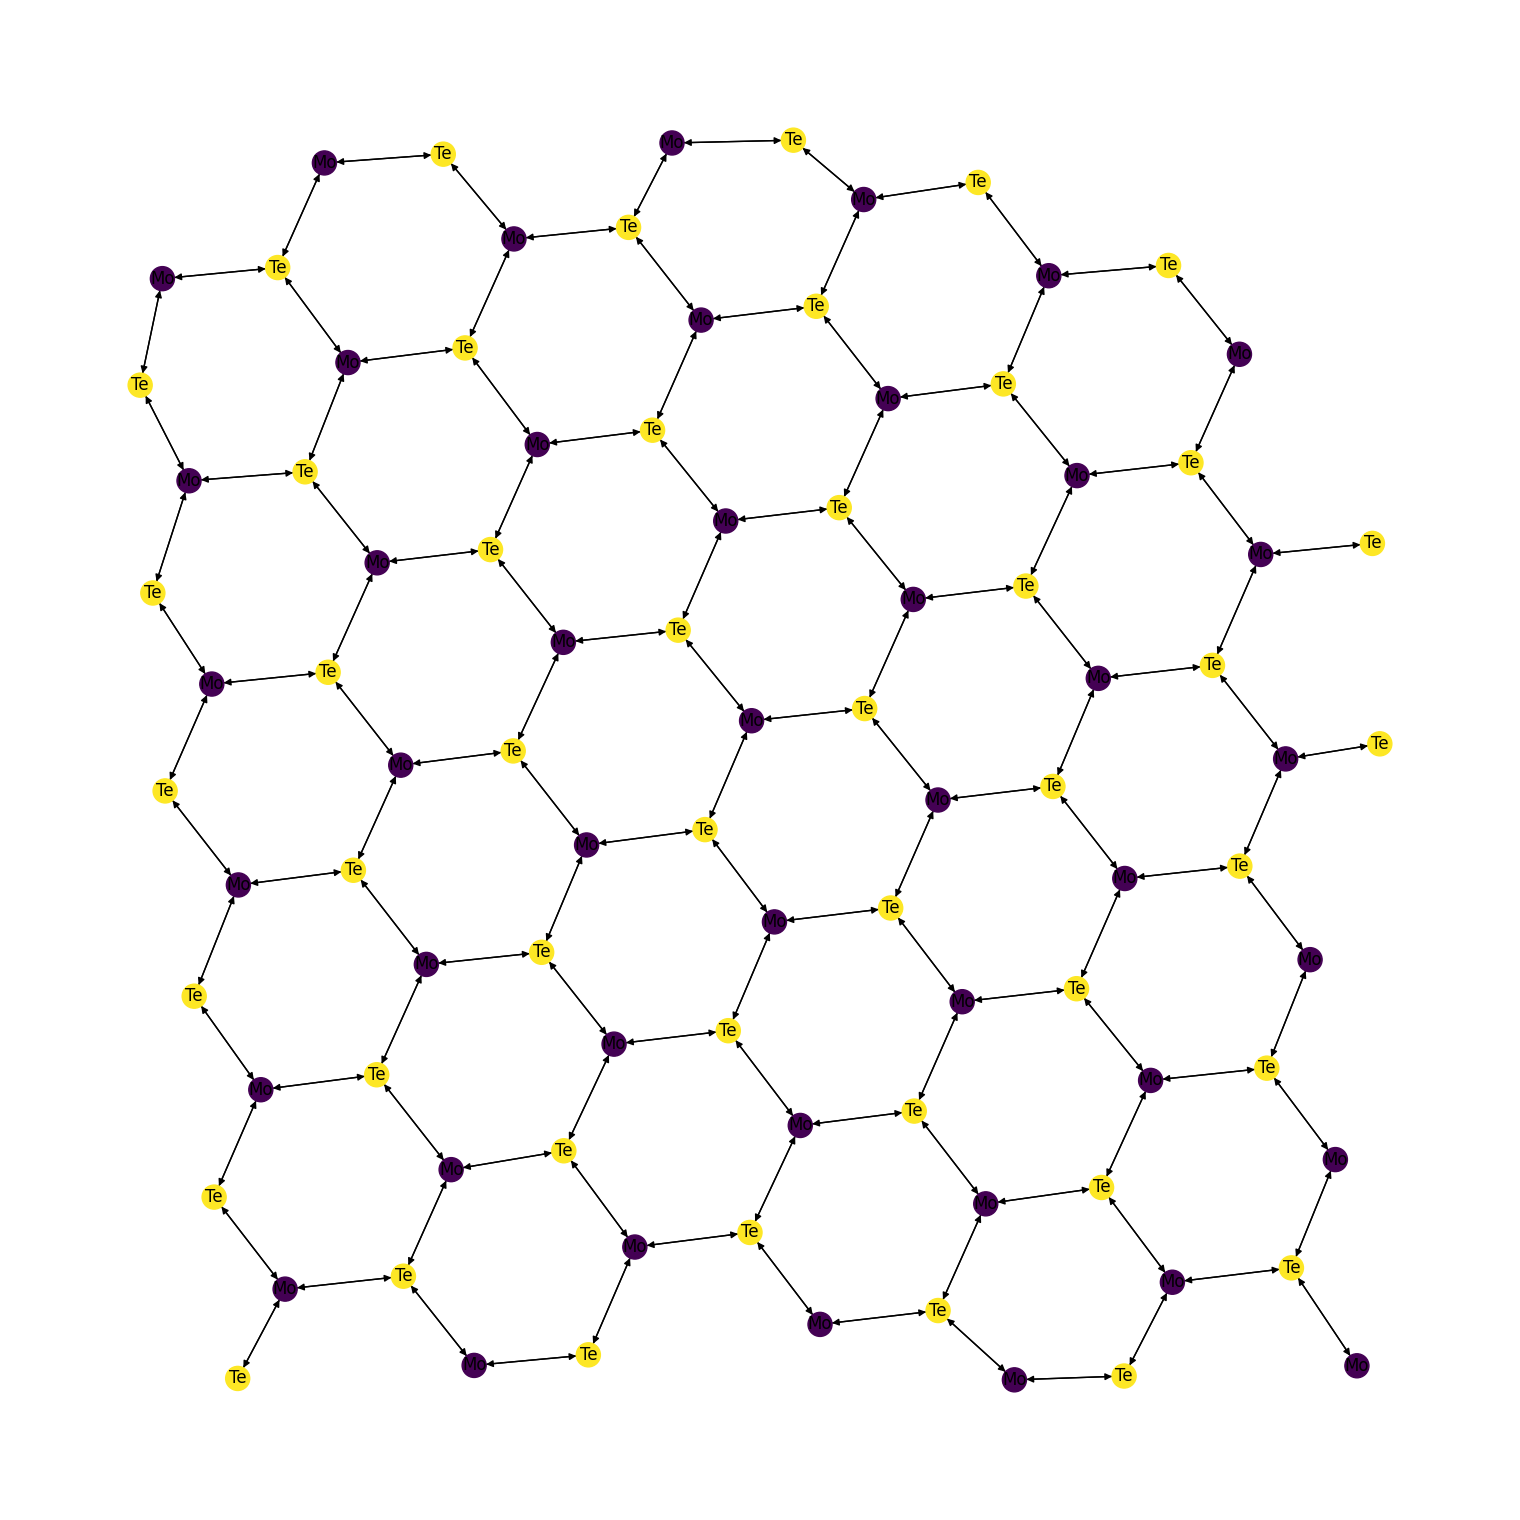

In [9]:
# 绘制图
pos = nx.get_node_attributes(G, 'x')
for key, value in pos.items():
    pos[key] = value[:2]

plt.figure(figsize=(15, 15))
# nx.draw(G, pos, with_labels=True, node_size=500, edge_color='gray', node_color=[G.nodes[n]['y'] for n in G.nodes], )
nx.draw(G, pos, with_labels=False, node_color=[G.nodes[n]['y'] for n in G.nodes])
node_labels = nx.get_node_attributes(G, 'y')
for key, value in node_labels.items():
    if value == 0:
        node_labels[key] = 'Mo'
    elif value == 1:
        node_labels[key] = 'Te'
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [13]:
# 图神经网络
import torch
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GATWithEmbedding(torch.nn.Module):
    def __init__(self, num_node_features, num_embed_features, hidden_channels, num_classes, num_heads=8):
        super(GATWithEmbedding, self).__init__()
        self.embedding = torch.nn.Linear(num_node_features, num_embed_features)
        self.conv1 = GATConv(num_embed_features, hidden_channels, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.embedding(x)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 训练函数
def train(model, loader, optimizer, criterion, epoch, total_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(loader, total=len(loader), desc=f'Epoch [{epoch+1}/{total_epochs}]')
    for data in loop:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 评估函数
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0  # 用于计算总节点数
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_nodes  # 累加当前批次的节点数
    return correct / total  # 返回准确率

In [14]:
# 设置模型、优化器和损失函数
num_node_features = 3  # 节点特征维度
num_embed_features = 16  # 嵌入层输出特征维度
hidden_channels = 16  # 隐藏层维度
num_classes = 2  # 类别数量
num_heads = 8  # 注意力头数量

model = GATWithEmbedding(num_node_features, num_embed_features, hidden_channels, num_classes, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


# 训练模型
num_epochs = 100

loss_list = []
step = 0
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, epoch, num_epochs)
    accuracy = evaluate(model, train_loader)
    loss_list.append((step, train_loss))
    step += 1
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/100]: 100%|██████████| 200/200 [00:07<00:00, 27.79it/s]


Epoch: 1, Loss: 1.2767, Accuracy: 0.5840


Epoch [2/100]: 100%|██████████| 200/200 [00:07<00:00, 28.50it/s]


Epoch: 2, Loss: 0.6622, Accuracy: 0.7195


Epoch [3/100]: 100%|██████████| 200/200 [00:07<00:00, 28.52it/s]


Epoch: 3, Loss: 0.4897, Accuracy: 0.9496


Epoch [4/100]: 100%|██████████| 200/200 [00:07<00:00, 28.57it/s]


Epoch: 4, Loss: 0.3742, Accuracy: 0.8905


Epoch [5/100]: 100%|██████████| 200/200 [00:07<00:00, 28.32it/s]


Epoch: 5, Loss: 0.2872, Accuracy: 0.9558


Epoch [6/100]: 100%|██████████| 200/200 [00:06<00:00, 28.57it/s]


Epoch: 6, Loss: 0.3096, Accuracy: 0.9836


Epoch [7/100]: 100%|██████████| 200/200 [00:06<00:00, 28.65it/s]


Epoch: 7, Loss: 0.2580, Accuracy: 0.9837


Epoch [8/100]: 100%|██████████| 200/200 [00:07<00:00, 28.22it/s]


Epoch: 8, Loss: 0.2397, Accuracy: 0.9846


Epoch [9/100]: 100%|██████████| 200/200 [00:06<00:00, 28.83it/s]


Epoch: 9, Loss: 0.2503, Accuracy: 0.9774


Epoch [10/100]: 100%|██████████| 200/200 [00:06<00:00, 28.78it/s]


Epoch: 10, Loss: 0.2262, Accuracy: 0.9843


Epoch [11/100]: 100%|██████████| 200/200 [00:06<00:00, 28.77it/s]


Epoch: 11, Loss: 0.2280, Accuracy: 0.9732


Epoch [12/100]: 100%|██████████| 200/200 [00:06<00:00, 28.69it/s]


Epoch: 12, Loss: 0.2328, Accuracy: 0.9871


Epoch [13/100]: 100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


Epoch: 13, Loss: 0.2390, Accuracy: 0.8506


Epoch [14/100]: 100%|██████████| 200/200 [00:07<00:00, 28.52it/s]


Epoch: 14, Loss: 0.2526, Accuracy: 0.9810


Epoch [15/100]: 100%|██████████| 200/200 [00:06<00:00, 28.87it/s]


Epoch: 15, Loss: 0.2155, Accuracy: 0.9831


Epoch [16/100]: 100%|██████████| 200/200 [00:06<00:00, 28.89it/s]


Epoch: 16, Loss: 0.2272, Accuracy: 0.9812


Epoch [17/100]: 100%|██████████| 200/200 [00:06<00:00, 28.84it/s]


Epoch: 17, Loss: 0.2063, Accuracy: 0.9889


Epoch [18/100]: 100%|██████████| 200/200 [00:06<00:00, 28.69it/s]


Epoch: 18, Loss: 0.2167, Accuracy: 0.9869


Epoch [19/100]: 100%|██████████| 200/200 [00:06<00:00, 28.75it/s]


Epoch: 19, Loss: 0.2155, Accuracy: 0.9630


Epoch [20/100]: 100%|██████████| 200/200 [00:06<00:00, 28.92it/s]


Epoch: 20, Loss: 0.2178, Accuracy: 0.9804


Epoch [21/100]: 100%|██████████| 200/200 [00:06<00:00, 28.60it/s]


Epoch: 21, Loss: 0.2189, Accuracy: 0.9727


Epoch [22/100]: 100%|██████████| 200/200 [00:06<00:00, 28.82it/s]


Epoch: 22, Loss: 0.2192, Accuracy: 0.9888


Epoch [23/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 23, Loss: 0.2212, Accuracy: 0.9546


Epoch [24/100]: 100%|██████████| 200/200 [00:06<00:00, 28.80it/s]


Epoch: 24, Loss: 0.2142, Accuracy: 0.9763


Epoch [25/100]: 100%|██████████| 200/200 [00:06<00:00, 28.78it/s]


Epoch: 25, Loss: 0.2178, Accuracy: 0.9883


Epoch [26/100]: 100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


Epoch: 26, Loss: 0.2156, Accuracy: 0.9088


Epoch [27/100]: 100%|██████████| 200/200 [00:07<00:00, 28.20it/s]


Epoch: 27, Loss: 0.2215, Accuracy: 0.9886


Epoch [28/100]: 100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


Epoch: 28, Loss: 0.2254, Accuracy: 0.9891


Epoch [29/100]: 100%|██████████| 200/200 [00:06<00:00, 28.68it/s]


Epoch: 29, Loss: 0.2111, Accuracy: 0.9886


Epoch [30/100]: 100%|██████████| 200/200 [00:06<00:00, 28.77it/s]


Epoch: 30, Loss: 0.2241, Accuracy: 0.9877


Epoch [31/100]: 100%|██████████| 200/200 [00:06<00:00, 28.76it/s]


Epoch: 31, Loss: 0.2007, Accuracy: 0.9906


Epoch [32/100]: 100%|██████████| 200/200 [00:06<00:00, 28.73it/s]


Epoch: 32, Loss: 0.2042, Accuracy: 0.9820


Epoch [33/100]: 100%|██████████| 200/200 [00:07<00:00, 28.36it/s]


Epoch: 33, Loss: 0.2037, Accuracy: 0.9891


Epoch [34/100]: 100%|██████████| 200/200 [00:06<00:00, 28.76it/s]


Epoch: 34, Loss: 0.2005, Accuracy: 0.9819


Epoch [35/100]: 100%|██████████| 200/200 [00:06<00:00, 28.84it/s]


Epoch: 35, Loss: 0.2053, Accuracy: 0.9641


Epoch [36/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 36, Loss: 0.2061, Accuracy: 0.9895


Epoch [37/100]: 100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


Epoch: 37, Loss: 0.2785, Accuracy: 0.9796


Epoch [38/100]: 100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


Epoch: 38, Loss: 0.2222, Accuracy: 0.9674


Epoch [39/100]: 100%|██████████| 200/200 [00:06<00:00, 29.01it/s]


Epoch: 39, Loss: 0.2042, Accuracy: 0.9899


Epoch [40/100]: 100%|██████████| 200/200 [00:06<00:00, 28.72it/s]


Epoch: 40, Loss: 0.2120, Accuracy: 0.9803


Epoch [41/100]: 100%|██████████| 200/200 [00:06<00:00, 28.90it/s]


Epoch: 41, Loss: 0.2058, Accuracy: 0.9880


Epoch [42/100]: 100%|██████████| 200/200 [00:06<00:00, 28.96it/s]


Epoch: 42, Loss: 0.2125, Accuracy: 0.9892


Epoch [43/100]: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Epoch: 43, Loss: 0.2031, Accuracy: 0.9767


Epoch [44/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 44, Loss: 0.2106, Accuracy: 0.9834


Epoch [45/100]: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Epoch: 45, Loss: 0.2197, Accuracy: 0.9800


Epoch [46/100]: 100%|██████████| 200/200 [00:07<00:00, 28.36it/s]


Epoch: 46, Loss: 0.2117, Accuracy: 0.9889


Epoch [47/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 47, Loss: 0.2110, Accuracy: 0.9869


Epoch [48/100]: 100%|██████████| 200/200 [00:06<00:00, 28.95it/s]


Epoch: 48, Loss: 0.2231, Accuracy: 0.9768


Epoch [49/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 49, Loss: 0.2102, Accuracy: 0.9873


Epoch [50/100]: 100%|██████████| 200/200 [00:06<00:00, 28.97it/s]


Epoch: 50, Loss: 0.2028, Accuracy: 0.9856


Epoch [51/100]: 100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


Epoch: 51, Loss: 0.2125, Accuracy: 0.9787


Epoch [52/100]: 100%|██████████| 200/200 [00:06<00:00, 28.83it/s]


Epoch: 52, Loss: 0.2093, Accuracy: 0.9845


Epoch [53/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 53, Loss: 0.2320, Accuracy: 0.9890


Epoch [54/100]: 100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


Epoch: 54, Loss: 0.2067, Accuracy: 0.9854


Epoch [55/100]: 100%|██████████| 200/200 [00:06<00:00, 29.03it/s]


Epoch: 55, Loss: 0.2045, Accuracy: 0.9848


Epoch [56/100]: 100%|██████████| 200/200 [00:06<00:00, 29.03it/s]


Epoch: 56, Loss: 0.2158, Accuracy: 0.9537


Epoch [57/100]: 100%|██████████| 200/200 [00:06<00:00, 28.92it/s]


Epoch: 57, Loss: 0.2155, Accuracy: 0.9813


Epoch [58/100]: 100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


Epoch: 58, Loss: 0.2162, Accuracy: 0.9895


Epoch [59/100]: 100%|██████████| 200/200 [00:07<00:00, 28.49it/s]


Epoch: 59, Loss: 0.2237, Accuracy: 0.9815


Epoch [60/100]: 100%|██████████| 200/200 [00:06<00:00, 29.05it/s]


Epoch: 60, Loss: 0.2064, Accuracy: 0.9704


Epoch [61/100]: 100%|██████████| 200/200 [00:06<00:00, 28.64it/s]


Epoch: 61, Loss: 0.2464, Accuracy: 0.9881


Epoch [62/100]: 100%|██████████| 200/200 [00:06<00:00, 28.84it/s]


Epoch: 62, Loss: 0.2143, Accuracy: 0.9580


Epoch [63/100]: 100%|██████████| 200/200 [00:06<00:00, 28.75it/s]


Epoch: 63, Loss: 0.2102, Accuracy: 0.9884


Epoch [64/100]: 100%|██████████| 200/200 [00:06<00:00, 28.63it/s]


Epoch: 64, Loss: 0.2137, Accuracy: 0.9709


Epoch [65/100]: 100%|██████████| 200/200 [00:07<00:00, 28.57it/s]


Epoch: 65, Loss: 0.2119, Accuracy: 0.9886


Epoch [66/100]: 100%|██████████| 200/200 [00:06<00:00, 28.84it/s]


Epoch: 66, Loss: 0.2050, Accuracy: 0.9856


Epoch [67/100]: 100%|██████████| 200/200 [00:06<00:00, 28.83it/s]


Epoch: 67, Loss: 0.2030, Accuracy: 0.9845


Epoch [68/100]: 100%|██████████| 200/200 [00:06<00:00, 28.82it/s]


Epoch: 68, Loss: 0.2030, Accuracy: 0.9420


Epoch [69/100]: 100%|██████████| 200/200 [00:06<00:00, 28.89it/s]


Epoch: 69, Loss: 0.2122, Accuracy: 0.9894


Epoch [70/100]: 100%|██████████| 200/200 [00:06<00:00, 28.79it/s]


Epoch: 70, Loss: 0.2228, Accuracy: 0.9821


Epoch [71/100]: 100%|██████████| 200/200 [00:06<00:00, 28.78it/s]


Epoch: 71, Loss: 0.2034, Accuracy: 0.9879


Epoch [72/100]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


Epoch: 72, Loss: 0.2141, Accuracy: 0.9887


Epoch [73/100]: 100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


Epoch: 73, Loss: 0.2010, Accuracy: 0.9869


Epoch [74/100]: 100%|██████████| 200/200 [00:06<00:00, 28.95it/s]


Epoch: 74, Loss: 0.2154, Accuracy: 0.9885


Epoch [75/100]: 100%|██████████| 200/200 [00:06<00:00, 28.74it/s]


Epoch: 75, Loss: 0.2248, Accuracy: 0.9886


Epoch [76/100]: 100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


Epoch: 76, Loss: 0.2053, Accuracy: 0.9769


Epoch [77/100]: 100%|██████████| 200/200 [00:06<00:00, 28.81it/s]


Epoch: 77, Loss: 0.2118, Accuracy: 0.9711


Epoch [78/100]: 100%|██████████| 200/200 [00:06<00:00, 28.92it/s]


Epoch: 78, Loss: 0.2028, Accuracy: 0.9873


Epoch [79/100]: 100%|██████████| 200/200 [00:06<00:00, 29.06it/s]


Epoch: 79, Loss: 0.2080, Accuracy: 0.9840


Epoch [80/100]: 100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


Epoch: 80, Loss: 0.2076, Accuracy: 0.9473


Epoch [81/100]: 100%|██████████| 200/200 [00:07<00:00, 28.42it/s]


Epoch: 81, Loss: 0.2137, Accuracy: 0.9693


Epoch [82/100]: 100%|██████████| 200/200 [00:07<00:00, 28.25it/s]


Epoch: 82, Loss: 0.2197, Accuracy: 0.9885


Epoch [83/100]: 100%|██████████| 200/200 [00:07<00:00, 28.37it/s]


Epoch: 83, Loss: 0.2117, Accuracy: 0.9889


Epoch [84/100]: 100%|██████████| 200/200 [00:07<00:00, 28.16it/s]


Epoch: 84, Loss: 0.2070, Accuracy: 0.9581


Epoch [85/100]: 100%|██████████| 200/200 [00:07<00:00, 28.45it/s]


Epoch: 85, Loss: 0.2092, Accuracy: 0.9892


Epoch [86/100]: 100%|██████████| 200/200 [00:06<00:00, 28.67it/s]


Epoch: 86, Loss: 0.2097, Accuracy: 0.9886


Epoch [87/100]: 100%|██████████| 200/200 [00:06<00:00, 29.02it/s]


Epoch: 87, Loss: 0.2110, Accuracy: 0.9787


Epoch [88/100]: 100%|██████████| 200/200 [00:06<00:00, 29.04it/s]


Epoch: 88, Loss: 0.2081, Accuracy: 0.9725


Epoch [89/100]: 100%|██████████| 200/200 [00:06<00:00, 28.98it/s]


Epoch: 89, Loss: 0.2134, Accuracy: 0.9868


Epoch [90/100]: 100%|██████████| 200/200 [00:06<00:00, 29.02it/s]


Epoch: 90, Loss: 0.2025, Accuracy: 0.9898


Epoch [91/100]: 100%|██████████| 200/200 [00:07<00:00, 28.32it/s]


Epoch: 91, Loss: 0.2082, Accuracy: 0.9869


Epoch [92/100]: 100%|██████████| 200/200 [00:06<00:00, 28.96it/s]


Epoch: 92, Loss: 0.2201, Accuracy: 0.9894


Epoch [93/100]: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Epoch: 93, Loss: 0.2048, Accuracy: 0.9786


Epoch [94/100]: 100%|██████████| 200/200 [00:06<00:00, 29.02it/s]


Epoch: 94, Loss: 0.2081, Accuracy: 0.9895


Epoch [95/100]: 100%|██████████| 200/200 [00:06<00:00, 28.90it/s]


Epoch: 95, Loss: 0.2176, Accuracy: 0.9898


Epoch [96/100]: 100%|██████████| 200/200 [00:06<00:00, 29.02it/s]


Epoch: 96, Loss: 0.2033, Accuracy: 0.9744


Epoch [97/100]: 100%|██████████| 200/200 [00:07<00:00, 28.56it/s]


Epoch: 97, Loss: 0.2071, Accuracy: 0.9883


Epoch [98/100]: 100%|██████████| 200/200 [00:06<00:00, 29.01it/s]


Epoch: 98, Loss: 0.2138, Accuracy: 0.9891


Epoch [99/100]: 100%|██████████| 200/200 [00:06<00:00, 29.00it/s]


Epoch: 99, Loss: 0.2039, Accuracy: 0.9839


Epoch [100/100]: 100%|██████████| 200/200 [00:06<00:00, 28.88it/s]


Epoch: 100, Loss: 0.2127, Accuracy: 0.9759


In [16]:
loss_list = np.array(loss_list)

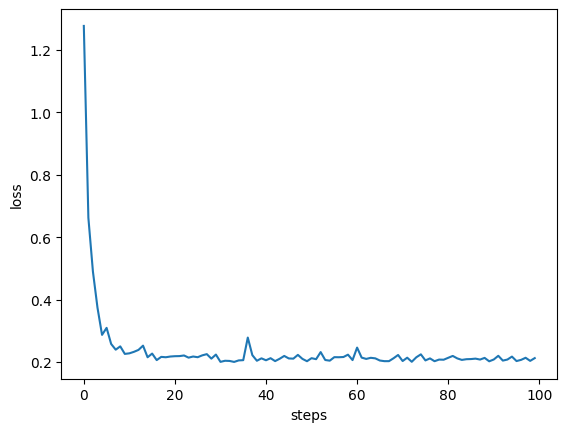

In [19]:
plt.plot(loss_list[:,0], loss_list[:,1])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [39]:
# 保存模型
torch.save(model.state_dict(), './results/gcn_model.pth')

In [13]:
# 加载模型
num_node_features = 3  # 节点特征维度
num_embed_features = 16  # 嵌入层输出特征维度
hidden_channels = 16  # 隐藏层维度
num_classes = 2  # 类别数量
num_heads = 8  # 注意力头数量
model = GATWithEmbedding(num_node_features, num_embed_features, hidden_channels, num_classes, num_heads)
model.load_state_dict(torch.load('./results/gcn_model.pth'))

<All keys matched successfully>

In [44]:
test_data = torch.load('F:\\QBC\\NKD\\data.pt')

In [15]:
model.eval()
out = model(dataset[10])
preds = out.argmax(dim=1)
dataset[10].y = preds

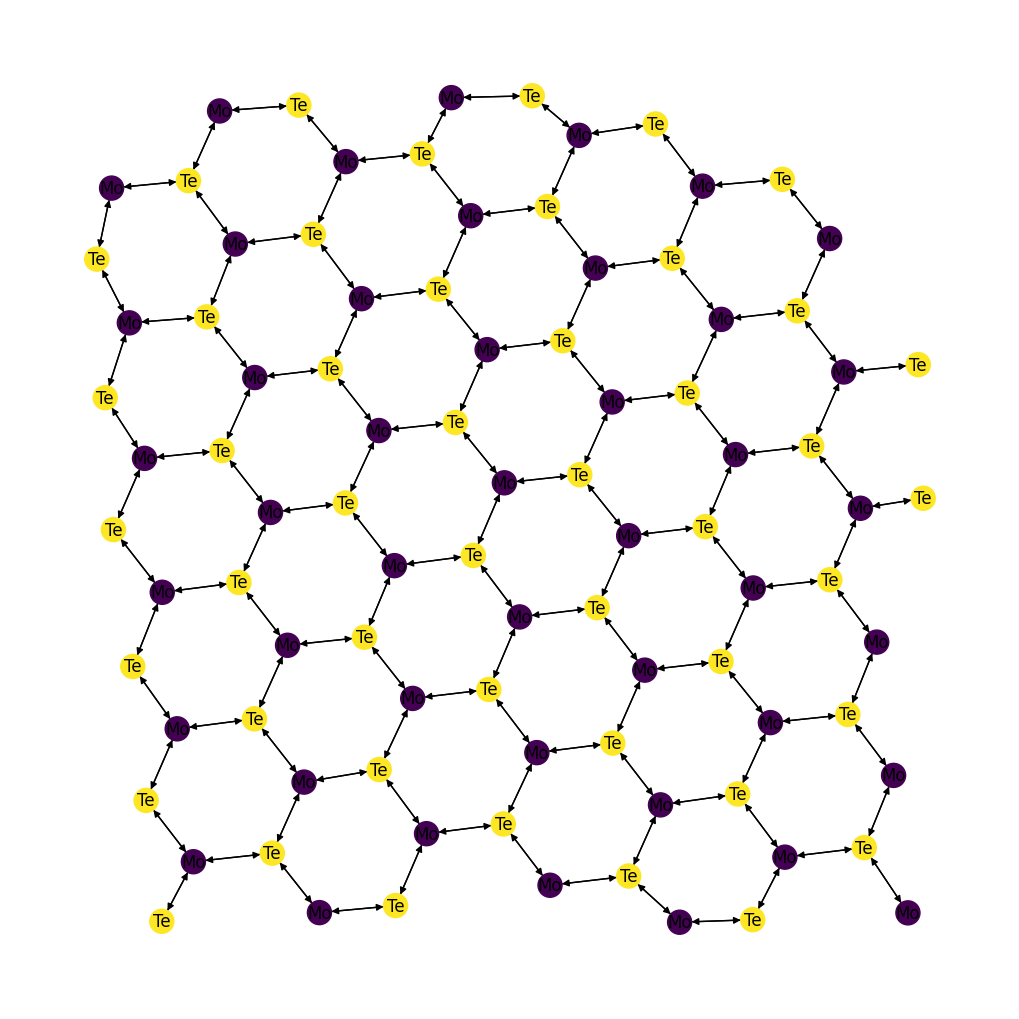

In [21]:
# 绘制图
G = to_networkx(dataset[10], node_attrs=['x', 'y'])
pos = nx.get_node_attributes(G, 'x')
for key, value in pos.items():
    pos[key] = value[:2]

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_color=[G.nodes[n]['y'] for n in G.nodes])
node_labels = nx.get_node_attributes(G, 'y')
for key, value in node_labels.items():
    if value == 0:
        node_labels[key] = 'Mo'
    elif value == 1:
        node_labels[key] = 'Te'
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()